In [4]:
import os
from collections import OrderedDict
import pandas as pd
from shapely import affinity
from shapely.geometry import MultiPoint
from scipy.optimize import minimize

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    x,y,angle = x0
    n_geom = mov(x,y,angle,geom2)
    return calc_dist(geom1,n_geom)

def df_to_od(df01):
    l = len(list(df01.itertuples()))
    ord_01 = OrderedDict()
    l = len(list(df01.itertuples()))
    for i in range(l):
        z = df01.loc[i]['Num']
        k = df01.loc[df01['Num'] == z]
        ord_01[list(k['Num'].iteritems())[0][1]]=(list(k['X'].iteritems())[0][1],list(k['Y'].iteritems())[0][1],list(k['Dist'].iteritems())[0][1])
    return ord_01

def od_to_df(od):
    #l = [[k,*od[k]] for k in od.keys()]
    l = []
    for k in od.keys():
        r = [k,od[k][0],od[k][1],od[k][2]]
        l.append(r)
    return pd.DataFrame.from_records(l,columns=['Num','X','Y','Dist'])

In [5]:
def chain_coords(path, original):
    distlist = []
    df01 = pd.read_csv(os.path.join(path,original),sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
    df01['Dist'] = ''
    for f in [i for i in os.listdir(path) if '.csv' in i and original not in i]:
        od_01 = df_to_od(df01)
        df02 = pd.read_csv(os.path.join(path,f),sep=';', names=['Num','X','Y'],dtype={'Num':'str','X':'float','Y':'float'})
        df01_c = df01.loc[df01['Num'].isin(list(df02['Num']))].sort_values(by='Num')
        df02_c = df02.loc[df02['Num'].isin(list(df01['Num']))].sort_values(by='Num')
        mp01_c = MultiPoint([i[2:4] for i in df01_c.itertuples()])
        mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
        mp02_c = MultiPoint([i[2:4] for i in df02_c.itertuples()])
 
        x_guess = mp01_c[0].x -mp02_c[0].x
        y_guess = mp01_c[0].y -mp02_c[0].y
        x0 = (x_guess,y_guess,0)
        
        re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='BFGS')
        
        if re.fun>0.002:
            newre = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')

            if newre.fun<re.fun:
                re = newre
        print(f)
        print(re.fun, len(mp02_c), re.fun/len(mp02_c))
        distlist.append([f,re.fun, len(mp02_c), re.fun/len(mp02_c)])
        x,y,angle = re.x
        mp02_c_moved =  mov(x,y,angle,mp02_c)
        ab = list(zip(mp01_c,mp02_c_moved))
        mp02_c_avg = MultiPoint([((i[0].x+i[1].x)/2,(i[0].y+i[1].y)/2) for i in ab])
        mp02_dist = [i[0].distance(i[1]) for i in ab]
        mp02_c_avg_dict = {k:v for k,v in zip(df02_c['Num'],list(zip(mp02_c_avg,mp02_dist)))}
        
        x,y,angle = re.x
        mp_moved = mov(x,y,angle,mp02)

        mp02_mov_dict = {k:v for k,v in zip(df02['Num'],list(zip(mp_moved,['']*len(mp_moved))))}
        for k in mp02_c_avg_dict.keys():
            mp02_mov_dict[k] = mp02_c_avg_dict[k]
        stag_02 = []
        for k in mp02_mov_dict.keys():
            row = [k,mp02_mov_dict[k][0].x,mp02_mov_dict[k][0].y,mp02_mov_dict[k][1]]
            stag_02.append(row)
        od_stag = OrderedDict({i[0]:(i[1],i[2],i[3]) for i in stag_02})
        for k in od_stag.keys():
            od_01[k] = od_stag[k]
        df01 = od_to_df(od_01)
    return df01,distlist

In [11]:
path = r'data/origint/ex'
original = '0000001_0990001.csv'

In [12]:
result,distlist = chain_coords(path, original)
result

0000002_0990002.csv
0.0007777391605410269 4 0.00019443479013525673
0000003_0990003.csv
0.0013935346624211462 4 0.00034838366560528656
0000004_0990004.csv
0.000969961219458201 4 0.00024249030486455026
0000005_0990005.csv
0.0013040306583864613 4 0.00032600766459661533
0000006_990005r.csv
0.000425505979954746 2 0.000212752989977373
0000007_0990006.csv
0.0012509103614527248 4 0.0003127275903631812
0000008_0990007.csv
0.00015394136843372718 3 5.131378947790906e-05
0000009_0990008.csv
0.000861056697376621 3 0.00028701889912554035
0000010_0990009.csv
0.0008282796667627649 3 0.00027609322225425497
0000011_0990010.csv
0.001284984131184324 3 0.00042832804372810795
0000012_0990011.csv
0.0025113709355320643 6 0.00041856182258867737
0000013_0990012.csv
0.002660818834763798 5 0.0005321637669527596
0000014_0990013.csv
0.0011627923212114855 4 0.0002906980803028714
0000015_0990015.csv
0.0021082867820371764 4 0.0005270716955092941
0000016_0990016.csv
0.0010986270363876637 4 0.00027465675909691593
000001

,Num,X,Y,Dist
0,6a,-32.440171,2.175778,7.10543e-15
1,7,-41.465703,1.645099,0.000554832
2,7b,-56.411133,1.329637,0.000155899
3,8,-70.667389,-5.257387,
4,7a,-55.487733,-4.691158,6.70079e-05
5,4,28.701654,-1.783774,
6,3,40.871366,-2.022232,
7,1,77.232177,-0.000022,
8,2,66.775321,5.272296,
9,1000,77.210089,1.844166,


In [16]:
from datetime import datetime

result.to_csv(r'res_{}.csv'.format(datetime.now().replace(' ','_').replace(':','_')),sep=';')


TypeError: an integer is required (got type str)

In [15]:
with open("distlist_{}.csv".format(datetime.now()).replace(' ','_').replace(':','_'),'w') as f:
    f.write("Файл стоянки;Общее расстояние;Количество общих точек;Среднее расстояние\n")
    for i in distlist:
        f.write("{};{}:{}:{}\n".format(i[0],i[1],i[2],i[3]))

In [32]:
from shapely.geometry import MultiPoint

import matplotlib.pyplot as plt
%matplotlib inline  

def plp(z,n):
    for p in z:        
        x = [i.x for i in p.geoms]
        y = [i.y for i in p.geoms]
        plt.figure(n)
        plt.plot(x,y,'ro')
        plt.plot(x,y,'ro')
    plt.show()
    

In [33]:
mp01 = MultiPoint([i[2:4] for i in result.itertuples()])

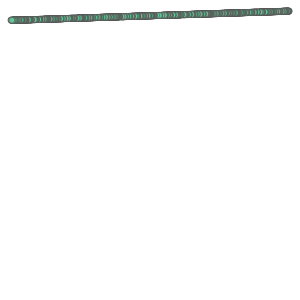

In [34]:
mp01

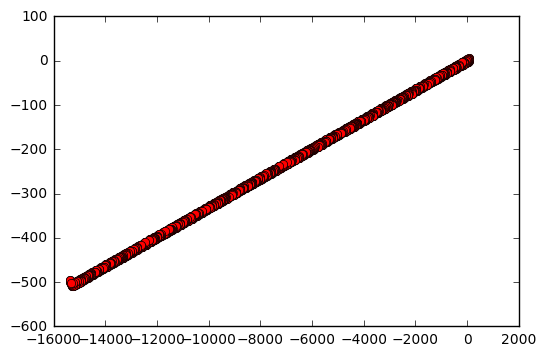

In [35]:
plp([mp01,],1)

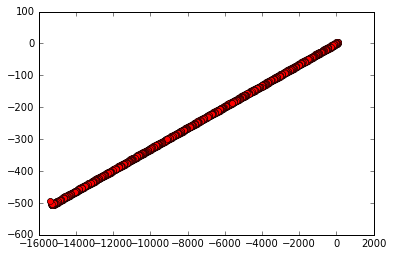

In [13]:
plp([mp01,],1)

gg

In [9]:
re.fun

NameError: name 're' is not defined

In [117]:
df01 = pd.read_csv(os.path.join(path,original),sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
df01['Dist'] = ''

f = [i for i in os.listdir(path) if '.csv' in i and original not in i][0]
print(f)
df02 = pd.read_csv(os.path.join(path,f),sep=';', names=['Num','X','Y'],dtype={'Num':'str','X':'float','Y':'float'})
df01_c = df01.loc[df01['Num'].isin(list(df02['Num']))].sort_values(by='Num')
df02_c = df02.loc[df02['Num'].isin(list(df01['Num']))].sort_values(by='Num')
mp01_c = MultiPoint([i[2:4] for i in df01_c.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_c.itertuples()])
x0 = (0,0,0)
re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')
mp02_c_moved =  mov(*re.x,mp02_c)
ab = list(zip(mp01_c,mp02_c_moved))
mp02_c_avg = MultiPoint([((i[0].x+i[1].x)/2,(i[0].y+i[1].y)/2) for i in ab])
mp02_dist = [i[0].distance(i[1]) for i in ab]
mp02_c_avg_dict = {k:v for k,v in zip(df02_c['Num'],list(zip(mp02_c_avg,mp02_dist)))}
print(re)
mp_moved = mov(*re.x,mp02)

mp02_mov_dict = {k:v for k,v in zip(df02['Num'],list(zip(mp_moved,['']*len(mp_moved))))}
print(mp02_mov_dict['605'][0].x)
for k in mp02_c_avg_dict.keys():
    mp02_mov_dict[k] = mp02_c_avg_dict[k]
stag_02 = []
for k in mp02_mov_dict.keys():
    row = [k,mp02_mov_dict[k][0].x,mp02_mov_dict[k][0].y,mp02_mov_dict[k][1]]
    stag_02.append(row)
stag_df = pd.DataFrame.from_records(stag_02,columns=['Num','X','Y','Dist'])
zz = pd.concat([df01,stag_df.rename(columns={'Num':'Num'})]).fillna(0).groupby('Num', as_index=False).last()

104.csv
     fun: 0.002081701982871198
     jac: array([   3.7404325 ,    2.57947205, -439.46588063,    0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 424
     nit: 71
    njev: 71
  status: 0
 success: True
       x: array([ -267.26849401,  2441.26995037,     9.99506175])
-14414.777335718443


In [19]:
zz

,Num,X,Y,Dist
0,597,-14227.175700,-336.142800,
1,596,-14205.796800,-321.824000,
2,598,-14252.269027,-340.045867,0.00036358
3,599,-14274.392002,-354.625009,1.77909e-05
4,600,-14299.916054,-358.684141,0.000840608
5,601,-14321.164081,-372.931802,0.000199619
6,602,-14346.579496,-376.987409,0.000264754
7,603,-14367.718779,-391.157282,0.000729077
8,595,-14180.551200,-317.862700,
9,593,-14133.887400,-299.583600,


In [81]:
df01

,Num,X,Y,Dist
0,597,-14227.1757,-336.1428,
1,596,-14205.7968,-321.8240,
2,598,-14252.2691,-340.0457,
3,599,-14274.3920,-354.6250,
4,600,-14299.9163,-358.6838,
5,601,-14321.1641,-372.9319,
6,602,-14346.5794,-376.9875,
7,603,-14367.7186,-391.1576,
8,595,-14180.5512,-317.8627,
9,593,-14133.8874,-299.5836,


Без усреднения: